In [1]:
import pandas as pd
import os
import pyarrow.feather as feather
from matplotlib import pyplot as plt
from tigramite import data_processing as pp
from tigramite import plotting as tp
from tigramite.pcmci import PCMCI
from tigramite.independence_tests import ParCorr
import numpy as np

# from tigramite.independence_tests import GPDC

# os.chdir("//Mac/Home/Desktop/PRJ/CO_SEPSIS")

# data_all = pd.read_csv("dat_FF.csv")



# Function for preparing the values of the variables specified by 'var_names'
# in the state specified by 'state' as numpy array of shape (T, N), where
# T is the number of time steps and N the number of variables
def get_data(data_all,  var_names=[r'$COPD$', r'$CO$', r'$NO$',r'$O_{3}$',
                                         r'$PM_{2.5}$', r'$SO_{2}$', r'$NO_{2}$',r'$PM_{10}$',
                                   r'$Season$',r'$Temp.$',r'$Humid.$']):
    # Select the state

    data_out = data_all

    # Select the columns
    data_out = data_out[var_names]

    # Turn into numpy array
    data_out = data_out.values

    # Return
    return data_out
    # Return
    return data_out


def get_data_and_mask(data_all, season, var_names):
    if season == "Year":
        data_out = get_data(data_all,  var_names)
        return data_out, None


    data_with_season = data_all.copy()

    # Select the state and columns, including 'season'
    data_with_season = data_with_season[var_names + [r'$Season$']]

    # Data without season
    data_out = data_with_season[var_names]
    data_out = data_out.values

    # Mask
    if season == "Summer":
        # Mask the winter months ('True' means masked, 'False' means not masked)
        data_with_season.loc[data_with_season[r'$Season$'] == 0, var_names] = True
        data_with_season.loc[data_with_season[r'$Season$'] == 1, var_names] = False
    elif season == "Winter":
        # Mask the sommer months ('True' means masked, 'False' means not masked)
        data_with_season.loc[data_with_season[r'$Season$'] == 0, var_names] = False
        data_with_season.loc[data_with_season[r'$Season$'] == 1, var_names] = True
    else:
        raise ValueError("Season must be in ['Year', 'Summer', 'Winter'].")
    mask_out = data_with_season[var_names]
    mask_out = mask_out.values

    # Return
    return data_out, mask_out


/Users/pei/.conda/envs/mbz/lib/python3.10/site-packages/tigramite/plotting.py:26: UserWarning: [Errno 2] No such file or directory: '/Users/pei/.conda/envs/mbz/lib/python3.10/site-packages/tigramite/../versions.py'
  warnings.warn(str(e))
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
/Users/pei/.conda/envs/mbz/lib/python3.10/site-packages/tigramite/independence_tests/gpdc.py:27: UserWarning: [Errno 2] No such file or directory: '/Users/pei/.conda/envs/mbz/lib/python3.10/site-packages/tigramite/independence_tests/../../versions.py'
  warnings.warn(str(e))
/Users/pei/.conda/envs/mbz/lib/python3.10/site-packages/tigramite/independence_tests/gpdc_torch.py:33: UserWarning: No module named 'gpytorch'
  warnings.warn(str(e))


In [2]:
data_all = pd.read_csv("20230222_COPD_TTTF.csv")
data_all.rename(columns={'copd': r'$COPD$',
                           'co': r'$CO$',
                          'no': r'$NO$',
                          'o3h8max': r'$O_{3}$',
                          'fsp': r'$PM_{2.5}$',
                          'so2': r'$SO_{2}$',
                          'no2': r'$NO_{2}$',
                         'rsp':r'$PM_{10}$',
#                          'dow': r'$DOW$',
#                           'dow2': r'$Season$',
                         'temp': r'$Temp.$',
                         'rh': r'$Humid.$'}, inplace=True)
data_all


,Unnamed: 0,date,dow,holiday,$Temp.$,$Humid.$,$CO$,$PM_{2.5}$,$NO$,$NO_{2}$,nox,o3,$O_{3}$,$PM_{10}$,$SO_{2}$,$COPD$
0,1,2005-01-01,1.050005,3.990633,-2.457233,-2.247166,-1.140999,-0.904420,-0.983209,-0.962292,-1.126798,0.729606,0.417638,-1.064986,-0.589759,-1.010596
1,2,2005-01-02,1.638397,-2.214403,-1.369281,-1.048869,0.323436,-0.287935,0.044704,0.070952,0.123890,-0.462416,-0.488614,-0.574755,-0.031752,1.234510
2,3,2005-01-03,-1.303563,-2.214403,-0.166181,-0.377096,2.364566,1.392789,3.362627,2.423914,3.435590,-1.177782,-0.937877,1.479054,2.615697,1.720153
3,4,2005-01-04,-0.967339,0.001682,0.234852,-1.248585,5.516282,3.216421,3.568879,2.576090,3.724189,-1.080575,-1.002708,3.033667,5.234427,-0.063193
4,5,2005-01-05,-0.715171,0.001682,0.290441,0.376378,1.088011,1.058571,-0.485816,-0.029372,-0.317944,0.527748,0.136555,0.734921,-0.208150,-0.063193
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4378,4379,2016-12-27,-1.050868,4.876333,-0.255334,-1.365508,-0.471429,-1.466340,-0.715087,-1.646360,-1.238742,-0.180086,-0.021658,-0.862173,0.070546,-1.192836
4379,4380,2016-12-28,-0.462476,0.000948,-1.323433,-1.138558,-1.408410,-0.301826,-0.566423,-0.794233,-0.738105,-0.059210,-0.458266,-0.269477,0.202314,-0.555926
4380,4381,2016-12-29,0.041908,-1.328769,0.222061,-1.077388,0.442751,0.136988,-0.378994,-0.439166,-0.447007,0.499279,-0.044597,0.190646,0.247888,-0.601444
4381,4382,2016-12-30,0.630300,-2.215203,0.357062,-0.314836,-0.496866,0.028435,-0.477515,-0.077963,-0.369983,-0.124725,-0.621602,0.257060,0.102732,-2.655477


In [3]:

var_names=[r'$COPD$', r'$CO$', r'$NO$',r'$O_{3}$',
                                          r'$PM_{2.5}$', r'$SO_{2}$', r'$NO_{2}$',r'$PM_{10}$',r'$Season$',
                                    r'$Temp.$',r'$Humid.$']

# dataplot = get_data(data_all,  var_names)
# dataplot = pp.DataFrame(dataplot, var_names=var_names)
# ax = tp.plot_timeseries(dataplot); plt.rcParams['figure.figsize'] = [25, 20]; 
# plt.show()

def get_selected_links(var_names, tau_min, tau_max):
    
    # Get index of the season variable, if it exists
    if r'$Season$' in var_names:
        season_idx = np.argwhere(np.array(var_names) == r'$Season$')[0, 0]
    else:
        season_idx = None

    # Get index of the temperature variable, if it exists
    if r'$Temp.$' in var_names:
        temp_idx = np.argwhere(np.array(var_names) == r'$Temp.$')[0, 0]
    else:
        temp_idx = None

    # Get index of the humidity variable, if it exists
    if r'$Humid.$' in var_names:
        humid_idx = np.argwhere(np.array(var_names) == r'$Humid.$')[0, 0]
    else:
        humid_idx = None

    # Build dictionary
    selected_links = {}
    
    for idx, var in enumerate(var_names):

        if var == r'$COPD$':
            # Flu may be influenced by all variables other than season at at lags
            # For the influence of season see below
            selected_links[idx] = [(other_idx, -tau) for other_idx, other_var in enumerate(var_names)
                                   for tau in range(tau_min, tau_max + 1) if other_var != r'$Season$']
        elif var == r'$Humid.$':
            # Humiditiy may be influenced by itself at all lags
            selected_links[idx] = [(idx, -tau) for tau in range(tau_min, tau_max + 1)]

            # Humidity may also be influenced by temperature at non-zero lags
            selected_links[idx] = [(temp_idx, -tau) for tau in range(max(1, tau_min), tau_max + 1)]

        elif var == r'$Temp.$':
            # Temperature may be influenced by itself at all lags
            selected_links[idx] = [(idx, -tau) for tau in range(tau_min, tau_max + 1)]

            # Temperature may also be influenced by humidity at non-zero lags
            selected_links[idx] = [(humid_idx, -tau) for tau in range(max(1, tau_min), tau_max + 1)]

        elif var == r'$Season$':
            # Season may be influenced by itself at all lags
            selected_links[idx] = [(idx, -tau) for tau in range(tau_min, tau_max + 1)]

        else:
            # All other variables, here this is O2, may be influenced by all variables other than
            # Flu and Season
            # For the influence of season see below
            selected_links[idx] = [(other_idx, -tau) for other_idx, other_var in enumerate(var_names)
                                   for tau in range(tau_min, tau_max + 1) if
                                   ((other_var != r'$COPD$') & (other_var != r'$Season$'))]
            
        # Season may influence all variables at lag tau_min
        if var != r'$Season$' and season_idx is not None:
            selected_links[idx].append((season_idx, -tau_min))

    # Return
    return selected_links




def apply_pcmci(data_all,
                var_names,
                season,
                tau_min,
                tau_max,
                pc_alpha,
                verbosity):
    # Get the data and mask
    data, mask = get_data_and_mask(data_all=data_all,
                                   season=season,
                                   var_names=var_names)

    # Prepare the DataFrame object
    dataframe = pp.DataFrame(data,
                             mask=mask,
                             var_names=var_names,
                             missing_flag=999.)

    # Prepare the independence test and PCMCI object
    if season == "Year":
        #        gpdc = GPDC()
        parcorr = ParCorr()
    else:
        #        gpdc = GPDC(mask_type='y')
        parcorr = ParCorr(mask_type='y')
    pcmci = PCMCI(dataframe=dataframe,
                  cond_ind_test=parcorr,
                  verbosity=verbosity)

    # Get the selected_links arguement
    selected_links = get_selected_links(var_names,
                                        tau_min,
                                        tau_max)

    # Run PCMCI^+ with these parameters
    results = pcmci.run_pcmciplus(tau_min=tau_min,
                                  tau_max=tau_max,
                                  pc_alpha=pc_alpha,
                                  selected_links=selected_links)
    
#     state="Overall"
#     c3d = results['val_matrix']
#     c2d = c3d.transpose(2, 0, 1).reshape(tau_max + 1, -1)
#     c_df = pd.DataFrame(c2d)
#     c_df_t = c_df.transpose()
#     c_df_t["state"] = "Overall"
#     feather.write_feather(c_df_t, 'finalc_df%s_%s.feather' % (state,season))

#     p3d = results['p_matrix']
#     p2d = p3d.transpose(2, 0, 1).reshape(tau_max + 1, -1)
#     p_df = pd.DataFrame(p2d)
#     p_df_t = p_df.transpose()
#     p_df_t["state"] = "Overall"
#     feather.write_feather(p_df_t, 'finalp_df%s_%s.feather' % (state,season))

#     l3d = results['graph']
#     l2d = l3d.transpose(2, 0, 1).reshape(tau_max + 1, -1)
#     l_df = pd.DataFrame(l2d)
#     l_df_t = l_df.transpose()
#     l_df_t["state"] = "Overall"
#     feather.write_feather(l_df_t, 'finall_df%s_%s.feather' % (state,season))


#     tp.plot_graph(
#         arrow_linewidth=12.0,
#         figsize=(12.91, 6),
#         vmin_edges=-0.5,
#         vmax_edges=0.5,
#         node_label_size=15,
#         link_label_fontsize=10,
#         val_matrix=results['val_matrix'],
#         graph=results['graph'],
#         var_names=var_names,
#         link_colorbar_label='cross-MCI (edges)',
#         node_colorbar_label='auto-MCI (nodes)',
#         label_fontsize=12,
#         network_lower_bound=0.2,
#         show_colorbar=1
#     );

    tp.plot_graph(
        arrow_linewidth=7.0,
        figsize=(4, 2.5),
#         figsize=(6, 4.5),
        vmin_edges=-0.5,
        vmax_edges=0.5,
        node_label_size=12,#13
        link_label_fontsize=11,
        val_matrix=results['val_matrix'],
        graph=results['graph'],
        var_names=var_names,
        link_colorbar_label='cross-MCI (edges)',
        node_colorbar_label='auto-MCI (nodes)',
        node_aspect=1,
#         node_size=0.2,
        node_size=0.4,
        label_fontsize=12,
        network_lower_bound=0.2,
        show_colorbar=0
    );

#     plt.suptitle("Six nodes",
#                  size=12,
#                  weight="semibold",
#                  color="gray",
#                  verticalalignment="top",
#                  horizontalalignment="center")
    plt.savefig('COPD_sub6.png', dpi=300,bbox_inches='tight')
    plt.show()
    
    # Plot time series graph    
#     tp.plot_time_series_graph(
#     figsize=(8, 8),
#     node_size=0.05,
#     val_matrix=results['val_matrix'],
#     graph=results['graph'],
#     var_names=var_names,
#     link_colorbar_label='MCI',
#     ); plt.show()

    return results





pc_alpha = 0.001
# pc_alpha = [0.001, 0.005, 0.01, 0.025, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.75,
#            0.8, 0.85, 0.9, 0.95]


In [7]:
def apply_pcmci(data_all,
                var_names,
                season,
                tau_min,
                tau_max,
                pc_alpha,
                verbosity,
               name):
    # Get the data and mask
    data, mask = get_data_and_mask(data_all=data_all,
                                   season=season,
                                   var_names=var_names)

    # Prepare the DataFrame object
    dataframe = pp.DataFrame(data,
                             mask=mask,
                             var_names=var_names,
                             missing_flag=999.)

    # Prepare the independence test and PCMCI object
    if season == "Year":
        #        gpdc = GPDC()
        parcorr = ParCorr()
    else:
        #        gpdc = GPDC(mask_type='y')
        parcorr = ParCorr(mask_type='y')
    pcmci = PCMCI(dataframe=dataframe,
                  cond_ind_test=parcorr,
                  verbosity=verbosity)

    # Get the selected_links arguement
    selected_links = get_selected_links(var_names,
                                        tau_min,
                                        tau_max)

    # Run PCMCI^+ with these parameters
    results = pcmci.run_pcmciplus(tau_min=tau_min,
                                  tau_max=tau_max,
                                  pc_alpha=pc_alpha,
                                  selected_links=selected_links)
    
    state="Overall"
    c3d = results['val_matrix']
    c2d = c3d.transpose(2, 0, 1).reshape(tau_max + 1, -1)
    c_df = pd.DataFrame(c2d)
    c_df_t = c_df.transpose()
    c_df_t["state"] = "Overall"
    feather.write_feather(c_df_t, '01finalc_df%s_%s.feather' % (state,season))

    p3d = results['p_matrix']
    p2d = p3d.transpose(2, 0, 1).reshape(tau_max + 1, -1)
    p_df = pd.DataFrame(p2d)
    p_df_t = p_df.transpose()
    p_df_t["state"] = "Overall"
    feather.write_feather(p_df_t, '01finalp_df%s_%s.feather' % (state,season))

    l3d = results['graph']
    l2d = l3d.transpose(2, 0, 1).reshape(tau_max + 1, -1)
    l_df = pd.DataFrame(l2d)
    l_df_t = l_df.transpose()
    l_df_t["state"] = "Overall"
    feather.write_feather(l_df_t, '01finall_df%s_%s.feather' % (state,season))


#     tp.plot_graph(
#         arrow_linewidth=12.0,
#         figsize=(12.91, 6),
#         vmin_edges=-0.5,
#         vmax_edges=0.5,
#         node_label_size=15,
#         link_label_fontsize=10,
#         val_matrix=results['val_matrix'],
#         graph=results['graph'],
#         var_names=var_names,
#         link_colorbar_label='cross-MCI (edges)',
#         node_colorbar_label='auto-MCI (nodes)',
#         label_fontsize=12,
#         network_lower_bound=0.2,
#         show_colorbar=1
#     );

    tp.plot_graph(
        arrow_linewidth=7.0,
#         figsize=(6, 5),
        figsize=(10, 5),
        vmin_edges=-0.5,
        vmax_edges=0.5,
        node_label_size=13,
        link_label_fontsize=7,
        val_matrix=results['val_matrix'],
        graph=results['graph'],
        var_names=var_names,
        link_colorbar_label='cross-MCI (edges)',
        node_colorbar_label='auto-MCI (nodes)',
        node_aspect=1,
#         node_size=0.2,
        node_size=0.35,
        label_fontsize=11,
        network_lower_bound=0.2,
        show_colorbar=1
    );

    plt.suptitle(name,
                 size=14,
                 weight="semibold",
                 color="gray",
                 verticalalignment="top",
                 horizontalalignment="center")
    plt.savefig('COPD_main05.png', dpi=300,bbox_inches='tight')
    plt.show()
    
    #Plot time series graph    
#     tp.plot_time_series_graph(
#     figsize=(12, 6),
#     node_size=0.05,
#     vmin_edges=-0.5,
#     vmax_edges=0.5,
#     val_matrix=results['val_matrix'],
#     graph=results['graph'],
#     var_names=var_names,
#     link_colorbar_label='MCI',
#     );plt.savefig('COPD_sub_ts.png', dpi=300,bbox_inches='tight')
#     plt.show()

    return results

In [8]:
def get_selected_links(var_names, tau_min, tau_max):
    
    # Get index of the season variable, if it exists
    if r'$Season$' in var_names:
        season_idx = np.argwhere(np.array(var_names) == r'$Season$')[0, 0]
    else:
        season_idx = None

    # Get index of the temperature variable, if it exists
    if r'$Temp.$' in var_names:
        temp_idx = np.argwhere(np.array(var_names) == r'$Temp.$')[0, 0]
    else:
        temp_idx = None

    # Get index of the humidity variable, if it exists
    if r'$Humid.$' in var_names:
        humid_idx = np.argwhere(np.array(var_names) == r'$Humid.$')[0, 0]
    else:
        humid_idx = None

    # Build dictionary
    selected_links = {}
    
    for idx, var in enumerate(var_names):

        if var == r'$COPD$':
            # Flu may be influenced by all variables other than season at at lags
            # For the influence of season see below
            selected_links[idx] = [(other_idx, -tau) for other_idx, other_var in enumerate(var_names)
                                   for tau in range(tau_min, tau_max + 1) if other_var != r'$Season$']
            
        elif var == r'$PM_{2.5}$':
            # Flu may be influenced by all variables other than season at at lags
            # For the influence of season see below
            selected_links[idx] = [(other_idx, -tau) for other_idx, other_var in enumerate(var_names)
                                   for tau in range(tau_min, tau_max + 1) if other_var != r'$COPD$']
            
            
        elif var == r'$Humid.$':
            # Humiditiy may be influenced by itself at all lags
            selected_links[idx] = [(idx, -tau) for tau in range(tau_min, tau_max + 1)]

            # Humidity may also be influenced by temperature at non-zero lags
            selected_links[idx] = [(temp_idx, -tau) for tau in range(max(1, tau_min), tau_max + 1)]

        elif var == r'$Temp.$':
            # Temperature may be influenced by itself at all lags
            selected_links[idx] = [(idx, -tau) for tau in range(tau_min, tau_max + 1)]

            # Temperature may also be influenced by humidity at non-zero lags
            selected_links[idx] = [(humid_idx, -tau) for tau in range(max(1, tau_min), tau_max + 1)]

        elif var == r'$Season$':
            # Season may be influenced by itself at all lags
            selected_links[idx] = [(idx, -tau) for tau in range(tau_min, tau_max + 1)]

        else:
            # All other variables, here this is O2, may be influenced by all variables other than
            # Flu and Season
            # For the influence of season see below
            selected_links[idx] = [(other_idx, -tau) for other_idx, other_var in enumerate(var_names)
                                   for tau in range(tau_min, tau_max + 1) if
                                   ((other_var != r'$COPD$') & (other_var != r'$PM_{2.5}$'))]
            
        # Season may influence all variables at lag tau_min
        if var != r'$Season$' and season_idx is not None:
            selected_links[idx].append((season_idx, -tau_min))

    # Return
    return selected_links


/Users/pei/.conda/envs/mbz/lib/python3.10/site-packages/pyarrow/feather.py:164: UserWarning: The DataFrame has column names of mixed type. They will be converted to strings and not roundtrip correctly.
  table = Table.from_pandas(df, preserve_index=preserve_index)
/Users/pei/.conda/envs/mbz/lib/python3.10/site-packages/pyarrow/feather.py:164: UserWarning: The DataFrame has column names of mixed type. They will be converted to strings and not roundtrip correctly.
  table = Table.from_pandas(df, preserve_index=preserve_index)
/Users/pei/.conda/envs/mbz/lib/python3.10/site-packages/pyarrow/feather.py:164: UserWarning: The DataFrame has column names of mixed type. They will be converted to strings and not roundtrip correctly.
  table = Table.from_pandas(df, preserve_index=preserve_index)


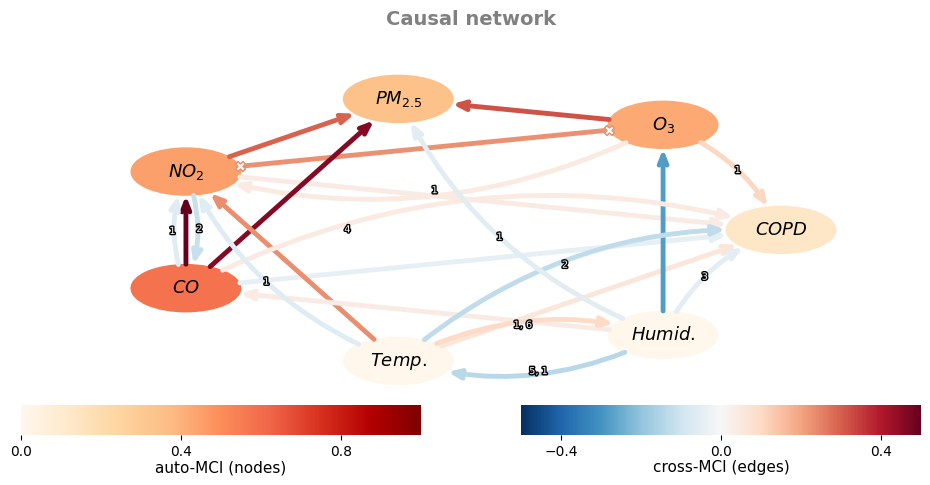

0.01


In [9]:
pc_alpha=0.01
results = apply_pcmci(data_all=data_all,
                      var_names=[r'$COPD$', r'$O_{3}$',r'$PM_{2.5}$',r'$NO_{2}$',r'$CO$',
                                 r'$Temp.$',r'$Humid.$'
                                    ],
                      season="Year",
                      tau_min=0,
                      tau_max=6,
                      pc_alpha=pc_alpha,
                      verbosity=0,
                      name="Causal network"
                      )
print(pc_alpha)

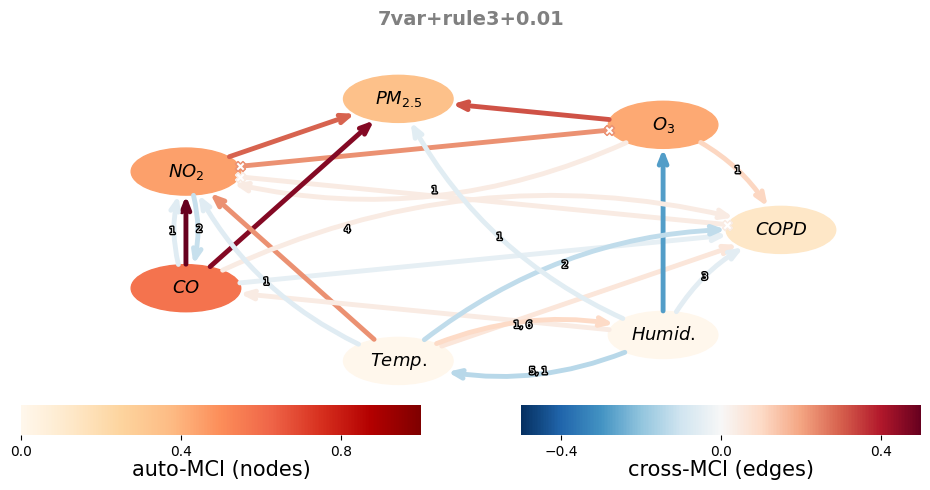

0.01


In [163]:
pc_alpha=0.01
results = apply_pcmci(data_all=data_all,
                      var_names=[r'$COPD$', r'$O_{3}$',r'$PM_{2.5}$',r'$NO_{2}$',r'$CO$',
                                 r'$Temp.$',r'$Humid.$'
                                    ],
                      season="Year",
                      tau_min=0,
                      tau_max=6,
                      pc_alpha=pc_alpha,
                      verbosity=0,
                      name="7var+rule3+0.01"
                      )
print(pc_alpha)

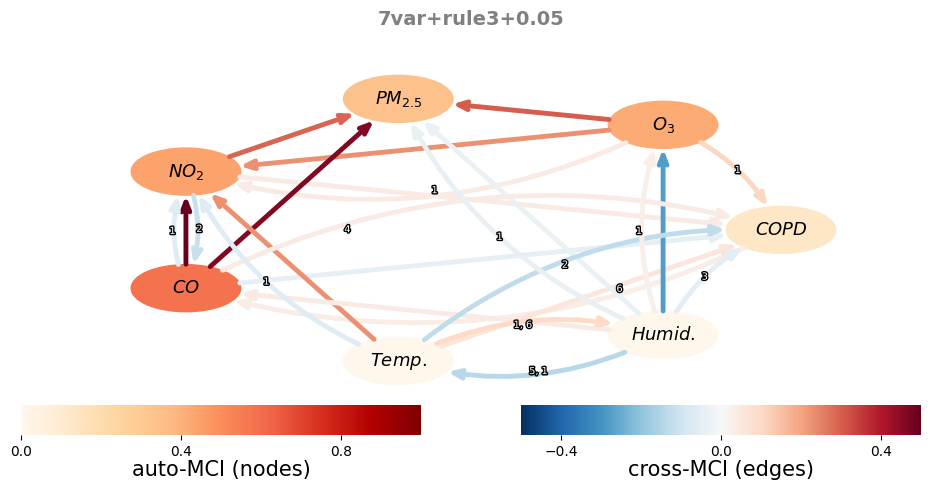

0.05


In [165]:
pc_alpha=0.05
results = apply_pcmci(data_all=data_all,
                      var_names=[r'$COPD$', r'$O_{3}$',r'$PM_{2.5}$',r'$NO_{2}$',r'$CO$',
                                 r'$Temp.$',r'$Humid.$'
                                    ],
                      season="Year",
                      tau_min=0,
                      tau_max=6,
                      pc_alpha=pc_alpha,
                      verbosity=0,
                      name="7var+rule3+0.05"
                      )
print(pc_alpha)

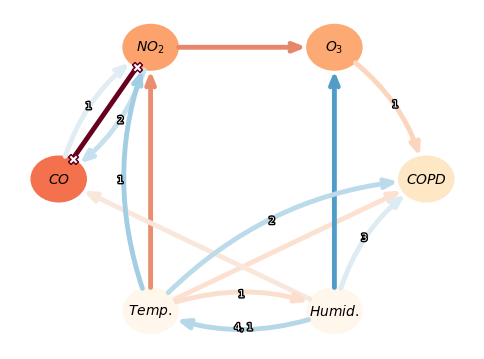

0.001


In [17]:
results = apply_pcmci(data_all=data_all,
                      var_names=[r'$COPD$', r'$O_{3}$',r'$NO_{2}$',r'$CO$',
                                 r'$Temp.$',r'$Humid.$'
                                    ],
                      season="Year",
                      tau_min=0,
                      tau_max=6,
                      pc_alpha=pc_alpha,
                      verbosity=0
                      )
print(pc_alpha)

In [ ]:
results = apply_pcmci(data_all=data_all,
                      var_names=[r'$COPD$', r'$O_{3}$',r'$NO_{2}$',r'$CO$',
                                 r'$Temp.$',r'$Humid.$'
                                    ],
                      season="Year",
                      tau_min=0,
                      tau_max=6,
                      pc_alpha=pc_alpha,
                      verbosity=0
                      )
print(pc_alpha)